In [31]:
import pandas as pd
import numpy as np 
import ast
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [32]:
# read datasets & create dataframes

comdata = pd.read_csv('Data/final_data.csv', index_col= 'Unnamed: 0')
ret_data = pd.read_csv('return_daily.csv', index_col='Unnamed: 0')

In [33]:
market_ret = ret_data[ret_data.index == 'mean']
# market_ret

In [34]:
stock_ret = ret_data.drop('mean', axis=0)
# stock_ret

In [35]:
# save small sample of data for testing
stock_ret.sample(100).to_csv("Data/test_stock_ret.csv")

In [36]:
def parse_isin_list(isin_str):
    # Convert string representation of list into actual list
    try:
        isin_list = ast.literal_eval(isin_str)
        # Replace 'None' and actual None with np.nan
        return [np.nan if (item is None or item == 'None') else item for item in isin_list]
    except:
        return []  # Return empty list if parsing fails

In [37]:
comdata['bidders_isin'] = comdata['bidders_isin'].apply(parse_isin_list)

In [38]:
df_exploded = comdata.explode('bidders_isin')
df_exploded['is_bidder'] = df_exploded['bidders_isin'].notna().astype(int)

In [39]:
df_exploded['targets_isin'] = df_exploded['targets_isin'].apply(parse_isin_list)

In [40]:
df_exploded = df_exploded.explode('targets_isin')
df_exploded['is_target'] = df_exploded['targets_isin'].notna().astype(int)

In [41]:
df_exploded.columns

Index(['number', 'date_completion', 'bidders_name', 'date_completion_assumed',
       'date_last_status_update', 'status', 'bidders_industry', 'id',
       'comments', 'targets_industry', 'targets_isin', 'date_rumor',
       'date_postponed', 'date_announcement', 'bidders_isin',
       'date_completion_expected', 'date_withdrawn', 'targets_country', 'type',
       'targets_name', 'bidders_country', 'sentences', 'cleaned_sentences',
       'stemmed_sentences', 'lemmatized_sentences', 'pos_tagged_sentences',
       'dependency_parsed_sentences', 'sentiment', 'vader_sentiment',
       'named_entities', 'topic', 'emotion', 'is_bidder', 'is_target'],
      dtype='object')

In [42]:
senti_cols = ['status', 'bidders_industry', 'bidders_isin', 'targets_industry', 
              'targets_isin', 'date_rumor', 'date_announcement', 'targets_country',
              'bidders_country', 'sentiment', 'vader_sentiment', 'named_entities', 
              'topic', 'emotion', 'is_bidder', 'is_target']

In [43]:
senti_df = df_exploded[senti_cols]

In [44]:
senti_df['ISIN'] = senti_df['bidders_isin'].str.cat(senti_df['targets_isin'], sep='', na_rep='')

C:\Users\kbeni\AppData\Local\Temp\ipykernel_144\1007740086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_df['ISIN'] = senti_df['bidders_isin'].str.cat(senti_df['targets_isin'], sep='', na_rep='')


In [45]:
senti_df.head()
senti_df.sample(100).to_csv("Data/test_senti.csv")

In [46]:
senti_df

,status,bidders_industry,bidders_isin,targets_industry,targets_isin,date_rumor,date_announcement,targets_country,bidders_country,sentiment,vader_sentiment,named_entities,topic,emotion,is_bidder,is_target,ISIN
0,Completed,['6499'],NaN,['2910'],INE451A01017,2014-07-31,2014-07-31,['IN'],['IN'],0.9118,positive,"[('20140801', 'DATE'), ('310714', 'CARDINAL'),...",3,"[('positive', 0.25)]",0,1,INE451A01017
1,Completed,['2931'],CNE100004C11,['2561'],NaN,2022-04-27,2022-04-27,['CN'],['CN'],0.3612,positive,"[('20220427', 'DATE'), ('automotive electronic...",4,"[('positive', 0.5)]",1,0,CNE100004C11
2,Completed Assumed,['2651'],CNE100000643,['4669'],NaN,2019-09-16,2019-09-16,['CN'],['CN'],0.2960,positive,"[(""'20190916"", 'DATE'), ('beijing', 'GPE'), ('...",1,"[('positive', 0.45)]",1,0,CNE100000643
3,Completed,['2932'],KYG693691092,['2932'],NaN,2015-06-02,2015-06-02,['SG'],['KY'],-0.2960,negative,"[(""'20150602"", 'DATE'), ('5 million', 'CARDINA...",4,"[('positive', 1.0)]",1,0,KYG693691092
4,Withdrawn,['4519'],NaN,['2931'],AU000000SIX0,2019-04-23,2019-04-23,['AU'],['CN'],0.9531,positive,"[('sprintex ltd', 'ORG'), ('11939765', 'DATE')...",3,"[('positive', 0.296875)]",0,1,AU000000SIX0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,Completed Assumed,['2930'],CNE1000022D8,['2932'],NaN,2016-03-23,2016-03-23,['CN'],['CN'],0.1779,positive,"[('20160323', 'DATE'), ('changzhou', 'GPE'), (...",1,"[('positive', 0.5263157894736842)]",1,0,CNE1000022D8
3391,Completed,['2219'],CNE100002F77,['2899'],NaN,2017-11-20,2017-11-20,['CN'],['CN'],0.0000,neutral,"[(""'20171120"", 'DATE'), ('51 per cent', 'MONEY...",1,"[('positive', 0.5555555555555556)]",1,0,CNE100002F77
3392,Completed,['2910'],KR7067170001,['2521'],NaN,2011-09-30,2011-09-30,['KR'],['KR'],0.5267,positive,"[(""'20110930"", 'DATE'), ('501 million', 'CARDI...",3,"[('positive', 0.36363636363636365)]",1,0,KR7067170001
3393,Completed Assumed,['2910'],CNE000000ZT3,[],NaN,2011-10-18,2011-10-18,[],['CN'],0.8225,positive,"[(""'20111018"", 'DATE'), ('dongfeng automobile ...",2,"[('positive', 0.4666666666666667)]",1,0,CNE000000ZT3


In [47]:
# Ensure the ISIN column in test_senti is standardized
senti_df['ISIN'] = senti_df['ISIN'].astype(str).str.strip().str.upper()

# Reset index of test_stock_ret to make ISIN a column
stock_ret.reset_index(inplace=True)
stock_ret.rename(columns={'index': 'ISIN'}, inplace=True)

C:\Users\kbeni\AppData\Local\Temp\ipykernel_144\2637885104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_df['ISIN'] = senti_df['ISIN'].astype(str).str.strip().str.upper()


In [48]:
stock_ret

,ISIN,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2023-12-15,2023-12-18,2023-12-19,2023-12-20,2023-12-21,2023-12-22,2023-12-26,2023-12-27,2023-12-28,2023-12-29
0,DE0005190003,0.009048,0.014069,0.009148,-0.011331,-0.014364,-0.034109,0.012520,0.009195,-0.006912,...,0.000974,-0.011877,-0.004532,-0.011580,-0.005407,0.010369,NaN,NaN,0.003789,0.001391
1,DE0007100000,-0.005603,-0.003329,-0.009155,0.000259,0.008556,-0.031749,0.008330,0.019979,-0.012972,...,0.017350,-0.012093,-0.009887,-0.010303,0.001602,0.007675,NaN,NaN,-0.011136,0.007079
2,DE0007664005,0.015633,0.001348,0.008022,0.014982,-0.010064,-0.024413,0.007301,-0.012360,-0.008695,...,-0.015091,-0.006855,-0.001218,0.003659,-0.024706,-0.000831,NaN,NaN,-0.015520,-0.000426
3,US88262P1021,0.056468,-0.025180,-0.008330,-0.025210,-0.002762,-0.005882,0.015308,-0.040771,-0.004639,...,-0.004190,0.003218,0.015602,-0.008406,0.002683,-0.001372,0.014055,-0.000903,-0.023769,-0.016063
4,DE0005439004,0.068941,0.006240,0.138334,0.022166,-0.063386,-0.043002,0.043728,-0.018061,-0.019836,...,0.010582,-0.008377,-0.000528,0.004754,-0.002366,0.005534,NaN,NaN,0.008179,0.007590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,AU0000224040,0.009296,-0.009211,0.016268,-0.008494,0.011862,-0.004559,0.000327,0.006540,-0.027940,...,0.007559,0.005359,0.010661,0.012658,-0.010417,0.013684,NaN,NaN,-0.012618,0.009585
214,CA98474P5013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024096,0.012346,0.012195,0.024096,0.000000,0.000000,NaN,NaN,0.023256,-0.011364
215,JP3955800002,-0.010000,0.008418,-0.050083,-0.010545,-0.001776,0.017794,-0.005245,-0.001757,0.007042,...,-0.009804,0.000000,-0.019802,0.030303,-0.009804,0.009901,NaN,NaN,0.000000,0.009804
216,CA98936C8584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,NaN,NaN,0.000000,0.000000


In [49]:
# search for ISIN DE0007856023 in stock_ret
stock_returns = stock_ret[stock_ret['ISIN'] == 'DE0007856023'].iloc[:, 1:]

In [50]:
# search for isin DE0007856023 in senti_df
senti_df[senti_df['ISIN'] == 'DE0007856023'].iloc[:, 17:]

""
889
1109
1110
1129
1976
2001
2050
2054
2448
2693


In [51]:
senti_df

,status,bidders_industry,bidders_isin,targets_industry,targets_isin,date_rumor,date_announcement,targets_country,bidders_country,sentiment,vader_sentiment,named_entities,topic,emotion,is_bidder,is_target,ISIN
0,Completed,['6499'],NaN,['2910'],INE451A01017,2014-07-31,2014-07-31,['IN'],['IN'],0.9118,positive,"[('20140801', 'DATE'), ('310714', 'CARDINAL'),...",3,"[('positive', 0.25)]",0,1,INE451A01017
1,Completed,['2931'],CNE100004C11,['2561'],NaN,2022-04-27,2022-04-27,['CN'],['CN'],0.3612,positive,"[('20220427', 'DATE'), ('automotive electronic...",4,"[('positive', 0.5)]",1,0,CNE100004C11
2,Completed Assumed,['2651'],CNE100000643,['4669'],NaN,2019-09-16,2019-09-16,['CN'],['CN'],0.2960,positive,"[(""'20190916"", 'DATE'), ('beijing', 'GPE'), ('...",1,"[('positive', 0.45)]",1,0,CNE100000643
3,Completed,['2932'],KYG693691092,['2932'],NaN,2015-06-02,2015-06-02,['SG'],['KY'],-0.2960,negative,"[(""'20150602"", 'DATE'), ('5 million', 'CARDINA...",4,"[('positive', 1.0)]",1,0,KYG693691092
4,Withdrawn,['4519'],NaN,['2931'],AU000000SIX0,2019-04-23,2019-04-23,['AU'],['CN'],0.9531,positive,"[('sprintex ltd', 'ORG'), ('11939765', 'DATE')...",3,"[('positive', 0.296875)]",0,1,AU000000SIX0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,Completed Assumed,['2930'],CNE1000022D8,['2932'],NaN,2016-03-23,2016-03-23,['CN'],['CN'],0.1779,positive,"[('20160323', 'DATE'), ('changzhou', 'GPE'), (...",1,"[('positive', 0.5263157894736842)]",1,0,CNE1000022D8
3391,Completed,['2219'],CNE100002F77,['2899'],NaN,2017-11-20,2017-11-20,['CN'],['CN'],0.0000,neutral,"[(""'20171120"", 'DATE'), ('51 per cent', 'MONEY...",1,"[('positive', 0.5555555555555556)]",1,0,CNE100002F77
3392,Completed,['2910'],KR7067170001,['2521'],NaN,2011-09-30,2011-09-30,['KR'],['KR'],0.5267,positive,"[(""'20110930"", 'DATE'), ('501 million', 'CARDI...",3,"[('positive', 0.36363636363636365)]",1,0,KR7067170001
3393,Completed Assumed,['2910'],CNE000000ZT3,[],NaN,2011-10-18,2011-10-18,[],['CN'],0.8225,positive,"[(""'20111018"", 'DATE'), ('dongfeng automobile ...",2,"[('positive', 0.4666666666666667)]",1,0,CNE000000ZT3


In [52]:
# calculate CARs
event_window = [-2, -1, 0, 1, 2]
baseline_window = range(-30, -3)

# Create a function to calculate CARs for each ISIN
def calculate_cars(isin, event_date):
    try:
        # Filter stock return data for the specific ISIN
        stock_returns = stock_ret[stock_ret['ISIN'] == isin].iloc[:, 1:]

        # Convert event_date to column format
        event_idx = stock_returns.columns.get_loc(event_date)

        # Event window returns
        event_indices = [event_idx + offset for offset in event_window]
        event_returns = stock_returns.iloc[:, event_indices].values.flatten()

        # Baseline mean return
        baseline_indices = [event_idx + offset for offset in baseline_window]
        baseline_returns = stock_returns.iloc[:, baseline_indices].values.flatten()
        expected_return = np.nanmean(baseline_returns)

        # Calculate abnormal returns and CARs
        abnormal_returns = event_returns - expected_return
        cars = np.nansum(abnormal_returns)
        return cars
    except Exception as e:
        return np.nan  # Return NaN if there is an issue


senti_df['CARs'] = senti_df.apply(
lambda row: calculate_cars(row['ISIN'], row['date_rumor']), axis=1
)

C:\Users\kbeni\AppData\Local\Temp\ipykernel_144\2762347394.py:21: RuntimeWarning: Mean of empty slice
  expected_return = np.nanmean(baseline_returns)
C:\Users\kbeni\AppData\Local\Temp\ipykernel_144\2762347394.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_df['CARs'] = senti_df.apply(


In [53]:
senti_df

,status,bidders_industry,bidders_isin,targets_industry,targets_isin,date_rumor,date_announcement,targets_country,bidders_country,sentiment,vader_sentiment,named_entities,topic,emotion,is_bidder,is_target,ISIN,CARs
0,Completed,['6499'],NaN,['2910'],INE451A01017,2014-07-31,2014-07-31,['IN'],['IN'],0.9118,positive,"[('20140801', 'DATE'), ('310714', 'CARDINAL'),...",3,"[('positive', 0.25)]",0,1,INE451A01017,0.0
1,Completed,['2931'],CNE100004C11,['2561'],NaN,2022-04-27,2022-04-27,['CN'],['CN'],0.3612,positive,"[('20220427', 'DATE'), ('automotive electronic...",4,"[('positive', 0.5)]",1,0,CNE100004C11,0.0
2,Completed Assumed,['2651'],CNE100000643,['4669'],NaN,2019-09-16,2019-09-16,['CN'],['CN'],0.2960,positive,"[(""'20190916"", 'DATE'), ('beijing', 'GPE'), ('...",1,"[('positive', 0.45)]",1,0,CNE100000643,0.0
3,Completed,['2932'],KYG693691092,['2932'],NaN,2015-06-02,2015-06-02,['SG'],['KY'],-0.2960,negative,"[(""'20150602"", 'DATE'), ('5 million', 'CARDINA...",4,"[('positive', 1.0)]",1,0,KYG693691092,0.0
4,Withdrawn,['4519'],NaN,['2931'],AU000000SIX0,2019-04-23,2019-04-23,['AU'],['CN'],0.9531,positive,"[('sprintex ltd', 'ORG'), ('11939765', 'DATE')...",3,"[('positive', 0.296875)]",0,1,AU000000SIX0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,Completed Assumed,['2930'],CNE1000022D8,['2932'],NaN,2016-03-23,2016-03-23,['CN'],['CN'],0.1779,positive,"[('20160323', 'DATE'), ('changzhou', 'GPE'), (...",1,"[('positive', 0.5263157894736842)]",1,0,CNE1000022D8,0.0
3391,Completed,['2219'],CNE100002F77,['2899'],NaN,2017-11-20,2017-11-20,['CN'],['CN'],0.0000,neutral,"[(""'20171120"", 'DATE'), ('51 per cent', 'MONEY...",1,"[('positive', 0.5555555555555556)]",1,0,CNE100002F77,0.0
3392,Completed,['2910'],KR7067170001,['2521'],NaN,2011-09-30,2011-09-30,['KR'],['KR'],0.5267,positive,"[(""'20110930"", 'DATE'), ('501 million', 'CARDI...",3,"[('positive', 0.36363636363636365)]",1,0,KR7067170001,0.0
3393,Completed Assumed,['2910'],CNE000000ZT3,[],NaN,2011-10-18,2011-10-18,[],['CN'],0.8225,positive,"[(""'20111018"", 'DATE'), ('dongfeng automobile ...",2,"[('positive', 0.4666666666666667)]",1,0,CNE000000ZT3,0.0


In [54]:
# Merge on ISIN
merged_data = pd.merge(senti_df, stock_ret, on='ISIN', how='inner')

# check if nan values are present
print(merged_data['CARs'].isnull().sum())

# drop nan values
merged_data = merged_data.dropna(subset=['CARs'])

# check if nan values are present
print(merged_data['CARs'].isnull().sum())

20
0


In [55]:
# Define dependent variable (CAR bzw. CAAR) and independent variables (Sentiment, Market Returns, ...)

X = merged_data[['sentiment']]  # adjust for actual data
y = merged_data['CARs'] # bzw. CAAR

X = X.dropna()
y = y[X.index]

In [56]:
# split data into training and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression


In [57]:
# fit regression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [58]:
# print coeff and intercept

print(f"Intercept: {model.intercept_}")
print(f"Sentiment Coefficient: {model.coef_[0]}")
print(f"Market Return Coefficient: {model.coef_[1]}")

Intercept: -0.00060412727192234
Sentiment Coefficient: 0.021244003957141003


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# Optionally, evaluate the model on the test set

y_pred = model.predict(X_test)
print(f"Predicted CAR: {y_pred}")
print(f"Actual CAR: {y_test.values}")

In [ ]:
# print R-squared value to check how well the model fits the data

print(f"R-squared: {model.score(X_test, y_test)}")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

# Make predictions and evaluate
y_pred = model.predict(X)
print("R-squared:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))

# Step 7: Interpret results
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients)

Ridge Regression

In [ ]:
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train, y_train)

In [ ]:
print(f"Ridge Intercept: {ridge_regressor.intercept_}")
print(f"Ridge Sentiment Coefficient: {ridge_regressor.coef_[0]}")
print(f"Ridge Market Return Coefficient: {ridge_regressor.coef_[1]}")

In [ ]:
print(ridge_regressor.summary())

Lasso Regression

In [ ]:
lasso_regressor = Lasso(alpha=0.1)
lasso_regressor.fit(X_train, y_train)

In [ ]:
print(f"Lasso Intercept: {lasso_regressor.intercept_}")
print(f"Lasso Sentiment Coefficient: {lasso_regressor.coef_[0]}")
print(f"Lasso Market Return Coefficient: {lasso_regressor.coef_[1]}")

In [ ]:
print(lasso_regressor.summary())

Decision Tree

In [ ]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

In [ ]:
print(f"Decision Tree Feature Importances: {dt_regressor.feature_importances_}")

Random Forest

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

In [ ]:
print(f"Random Forest Feature Importances: {rf_regressor.feature_importances_}")

In [ ]:
# # visualize CARs from 10 ISINs over time
# import matplotlib.pyplot as plt
#
# # Select 10 ISINs for visualization
# isin_list = senti_df['ISIN'].unique()[:10]
#
# # Filter data for the selected ISINs
# selected_data = senti_df[senti_df['ISIN'].isin(isin_list)]
#
# # Group by date to calculate average CARs per day
# car_trend = selected_data.groupby('date_rumor')['CARs'].mean().dropna()
#
# print(car_trend)
#
# # Plot CAR trends over time
# plt.figure(figsize=(15, 8))
# plt.plot(car_trend.index, car_trend.values, marker='o', linestyle='-', color='b')
# plt.title('CAR Trends Over Time for 10 ISINs', fontsize=16)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Average CAR', fontsize=14)
# plt.grid(axis='both', linestyle='--', alpha=0.7)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [59]:
# select rows from senti_df where CARs is not 0
senti_df = senti_df[senti_df['CARs'] != 0]

In [60]:
# check if nan values are present
print(senti_df['CARs'].isnull().sum())

# drop nan values
senti_df = senti_df.dropna(subset=['CARs'])

# check if nan values are present
print(senti_df['CARs'].isnull().sum())

senti_df

403
0


,status,bidders_industry,bidders_isin,targets_industry,targets_isin,date_rumor,date_announcement,targets_country,bidders_country,sentiment,vader_sentiment,named_entities,topic,emotion,is_bidder,is_target,ISIN,CARs
6,Completed Assumed,['2211'],JP3955800002,['4532'],NaN,2021-12-15,2021-12-15,['MY'],['JP'],0.4939,positive,"[('20211215', 'DATE'), ('the yokohama rubber c...",3,"[('positive', 0.3333333333333333)]",1,0,JP3955800002,-0.012275
23,Rumour - Expired,['2932'],NL0015001KT6,['2651'],NaN,2020-05-12,NaN,['IT'],['IT'],-0.2960,negative,"[('20200512', 'DATE'), ('80 per cent', 'MONEY'...",3,"[('positive', 0.5)]",1,0,NL0015001KT6,-0.106815
28,Completed,['2651'],US37253A1034,['2932'],NaN,2011-01-04,2011-01-04,['US'],['US'],0.4767,positive,"[('20110104', 'DATE'), ('amerigon inc', 'ORG')...",1,"[('positive', 0.5)]",1,0,US37253A1034,0.006729
39,Completed,['2910'],NaN,['2910'],CNE100000312,2022-09-23,2022-09-23,['CN'],['CN'],0.5267,positive,"[('20220926', 'DATE'), ('dongfeng motor corpor...",3,"[('trust', 0.3333333333333333), ('positive', 0...",0,1,CNE100000312,0.066469
43,Completed,['2910'],NaN,['2910'],CNE100000312,2022-11-21,2022-11-21,['CN'],['CN'],0.9118,positive,"[('20221125', 'DATE'), ('dongfeng motor', 'ORG...",3,"[('positive', 0.4666666666666667)]",0,1,CNE100000312,-0.036914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,Completed,['2910'],NaN,['2910'],CNE100000312,2022-10-24,2022-10-24,['CN'],['CN'],0.9118,positive,"[('20221028', 'DATE'), ('dongfeng motor', 'ORG...",3,"[('positive', 0.4666666666666667)]",0,1,CNE100000312,-0.024634
3309,Completed,['2932'],NL0015001KT6,[],NaN,2011-05-23,2011-05-23,[],['IT'],0.4939,positive,"[(""'20110523"", 'DATE'), ('75 per cent', 'MONEY...",3,"[('positive', 0.4)]",1,0,NL0015001KT6,-0.032764
3333,Completed,['2910'],NaN,['2910'],CNE100000312,2022-11-14,2022-11-14,['CN'],['CN'],0.6369,positive,"[(""'20221118"", 'DATE'), ('between 141122 and 1...",1,"[('positive', 0.375)]",0,1,CNE100000312,0.053070
3335,Completed Assumed,['2211'],FR001400AJ45,['4520'],NaN,2013-07-01,2013-07-01,['DK'],['FR'],0.0000,neutral,"[('20130701', 'DATE'), ('compagnie generale de...",3,"[('trust', 0.6666666666666666)]",1,0,FR001400AJ45,0.048255


In [61]:
# select CARs that are greater than 0.1 and less than -0.1
senti_df = senti_df[(senti_df['CARs'] > 0.1) | (senti_df['CARs'] < -0.1)]


In [62]:
# merge on ISIN
merged_data = pd.merge(senti_df, stock_ret, on='ISIN', how='inner')
merged_data

,status,bidders_industry,bidders_isin,targets_industry,targets_isin,date_rumor,date_announcement,targets_country,bidders_country,sentiment,...,2023-12-15,2023-12-18,2023-12-19,2023-12-20,2023-12-21,2023-12-22,2023-12-26,2023-12-27,2023-12-28,2023-12-29
0,Rumour - Expired,['2932'],NL0015001KT6,['2651'],NaN,2020-05-12,NaN,['IT'],['IT'],-0.2960,...,0.026291,0.008234,-0.001815,0.008182,0.004509,0.018851,NaN,NaN,0.001786,-0.001783
1,Completed,['2932'],NO0003033102,['2932'],NaN,2013-01-22,2013-01-22,['CN'],['NO'],-0.2960,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000
2,Completed,['2211'],ID1000086002,['2060'],NaN,2018-07-02,2018-07-02,['ID'],['ID'],0.4767,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,NaN,NaN,0.000000,0.000000
3,Completed,['2910'],NaN,['2910'],IT0003056386,2015-03-30,2016-07-01,['IT'],['NL'],0.9769,...,0.000000,0.000000,0.013514,-0.013333,-0.013514,0.027397,NaN,NaN,-0.013158,0.000000
4,Rumour - Expired,['2910'],KYG3777B1032,['2910'],NaN,2019-01-17,NaN,['IT'],['KY'],-0.0516,...,0.000000,-0.021053,0.000000,-0.021505,0.010989,-0.021739,NaN,NaN,0.076923,0.010204
5,Completed Assumed,['2910'],KYG3777B1032,['2910'],NaN,2021-10-18,2021-10-29,['KY'],['KY'],0.9645,...,0.000000,-0.021053,0.000000,-0.021505,0.010989,-0.021739,NaN,NaN,0.076923,0.010204
6,Completed,['4677'],US5018892084,[],NaN,2016-02-29,2016-02-29,[],['US'],0.8316,...,0.004739,0.028302,-0.013761,0.009302,0.000000,-0.013825,NaN,NaN,-0.004630,0.004651
7,Completed,['2932'],AU0000340770,['2932'],NaN,2021-11-30,2021-11-30,['AU'],['AU'],0.9485,...,-0.006993,0.000000,0.014085,0.006944,-0.006897,0.006944,NaN,NaN,0.013889,0.000000
8,Completed,['2932'],FR0000124570,['2932'],NaN,2010-06-17,2010-07-28,['FR'],['FR'],0.9493,...,0.001642,0.000000,-0.004918,0.002471,-0.001643,-0.000823,NaN,NaN,0.018364,-0.011475
9,Completed,['4677'],US5018892084,['4531'],NaN,2012-04-26,2013-04-25,['NL'],['US'],0.0772,...,0.004739,0.028302,-0.013761,0.009302,0.000000,-0.013825,NaN,NaN,-0.004630,0.004651


In [ ]:
# # reduce merged_data to 3 entries
# merged_data = merged_data.sample(3)
#
#
# # Iterate through each ISIN in the filtered dataset
# for isin in merged_data['ISIN'].unique():
#     # Filter data for the specific ISIN
#     isin_data = merged_data[merged_data['ISIN'] == isin]
#
#     # Extract the date columns (assuming they are in the format 'YYYY-MM-DD')
#     daily_returns = isin_data.filter(regex=r'\d{4}-\d{2}-\d{2}')
#
#     print(daily_returns)
#
#     # Select weekly data (e.g., every 7th column)
#     weekly_returns = daily_returns.iloc[:, ::14]
#
#     # Plot daily returns over time
#     plt.figure(figsize=(12, 6))
#     plt.plot(weekly_returns.columns, weekly_returns.iloc[0], marker='o', linestyle='-', color='b')
#     plt.title(f'Daily Returns Over Time for ISIN: {isin}', fontsize=16)
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Daily Return', fontsize=14)
#     plt.grid(axis='both', linestyle='--', alpha=0.7)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # reduce merged_data to 3 entries
# merged_data = merged_data.sample(3)

import pandas as pd
import matplotlib.pyplot as plt

# Iterate through each ISIN in the filtered dataset
for isin in merged_data['ISIN'].unique():
    # Filter data for the specific ISIN
    isin_data = merged_data[merged_data['ISIN'] == isin]

    # Get the rumor_date for this ISIN (assuming there's only one row per ISIN)
    rumor_date = pd.to_datetime(isin_data['date_rumor'].values[0])

    # Calculate the date range (2 weeks before and 2 weeks after)
    start_date = rumor_date - pd.Timedelta(weeks=2)
    end_date = rumor_date + pd.Timedelta(weeks=2)

    # Extract the date columns within the range
    daily_returns = isin_data.filter(regex=r'\d{4}-\d{2}-\d{2}')
    date_columns = pd.to_datetime(daily_returns.columns)
    relevant_mask = (date_columns >= start_date) & (date_columns <= end_date)
    relevant_columns = date_columns[relevant_mask]
    relevant_data = daily_returns.iloc[:, relevant_mask]

    # Plot the relevant data
    plt.figure(figsize=(12, 6))
    plt.plot(relevant_columns, relevant_data.iloc[0], marker='o', linestyle='-', color='b')
    plt.axvline(rumor_date, color='r', linestyle='--', label='Rumor Date')
    plt.title(f'Daily Returns (2 Weeks Before & After Rumor Date) for ISIN: {isin}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Daily Return', fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


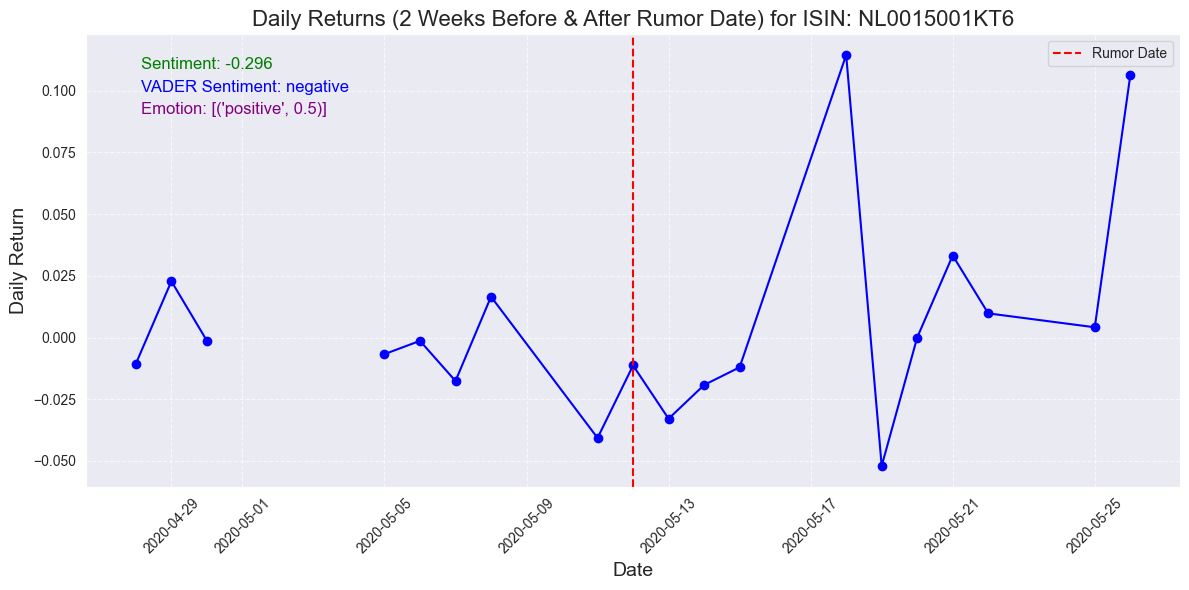

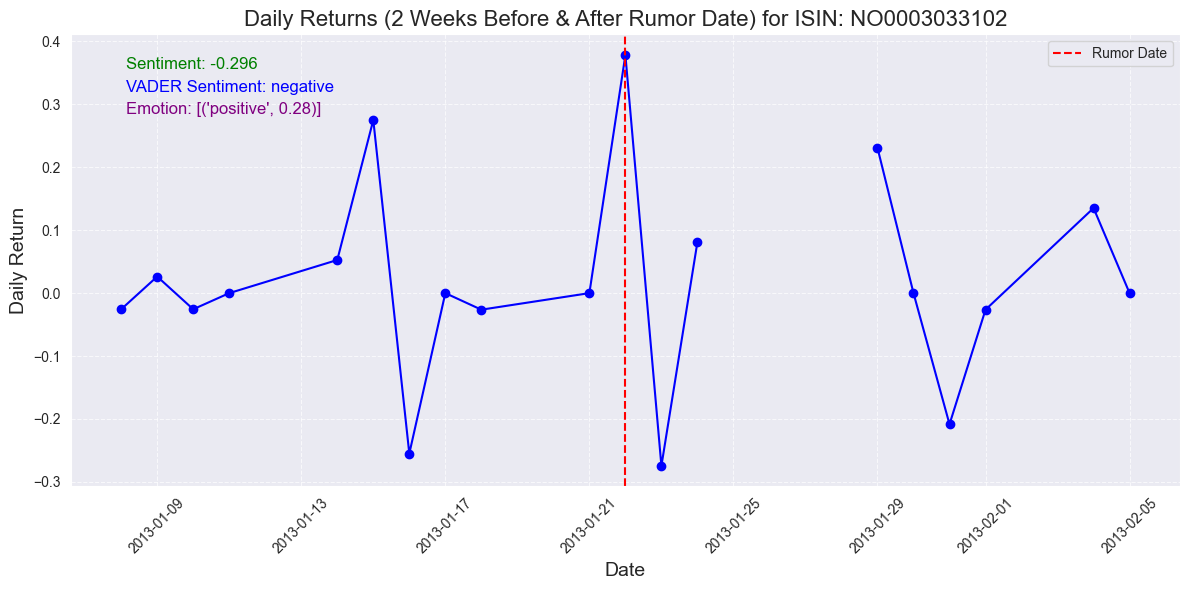

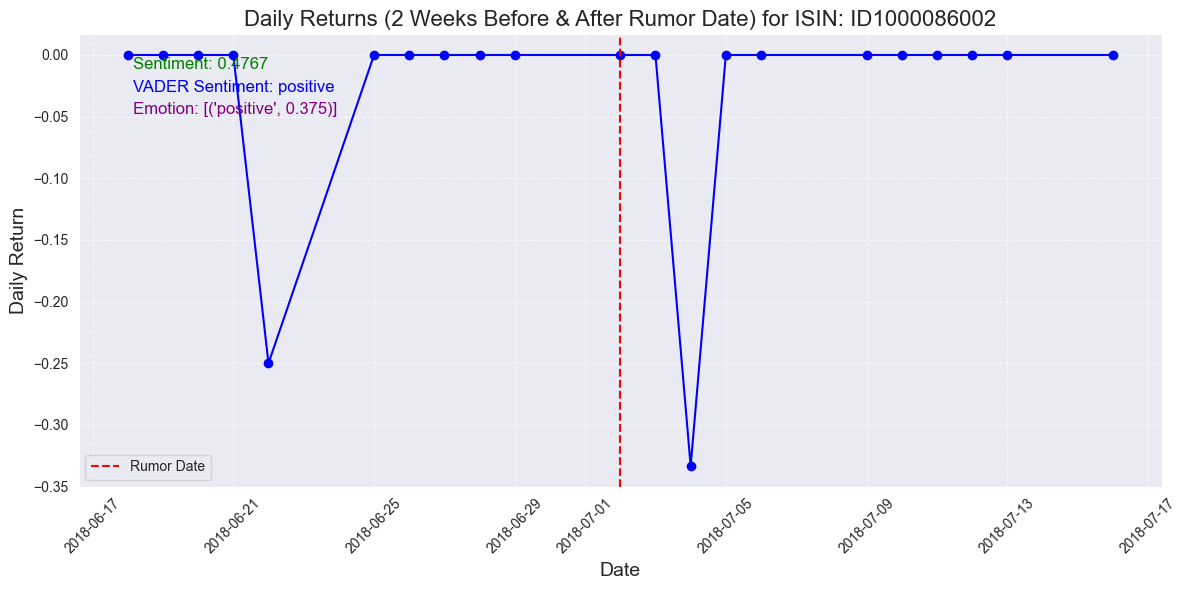

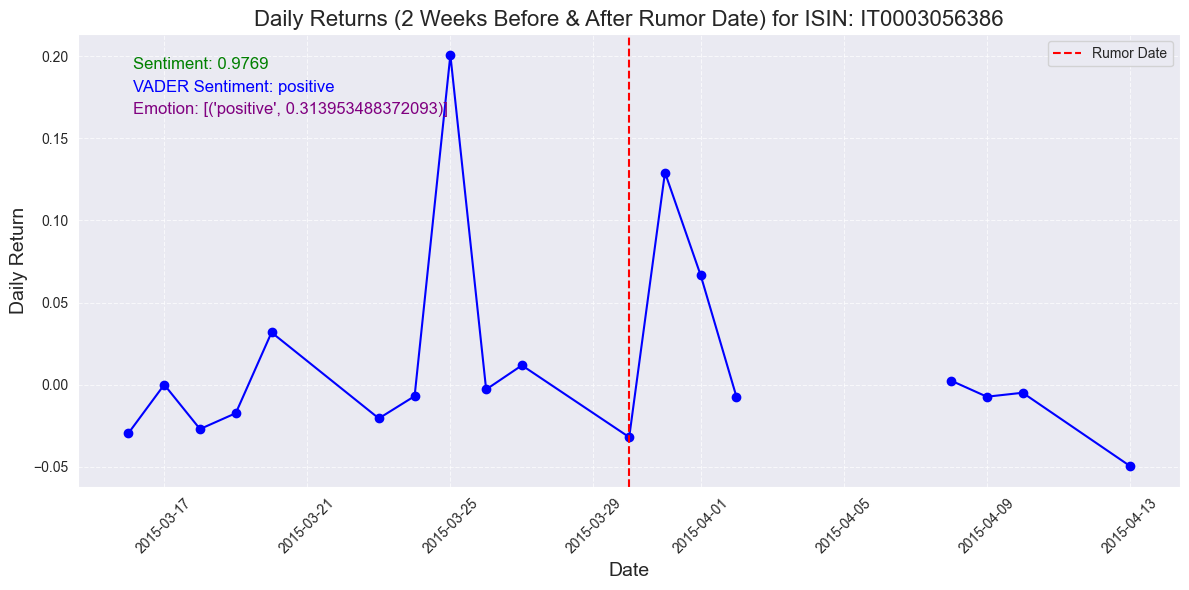

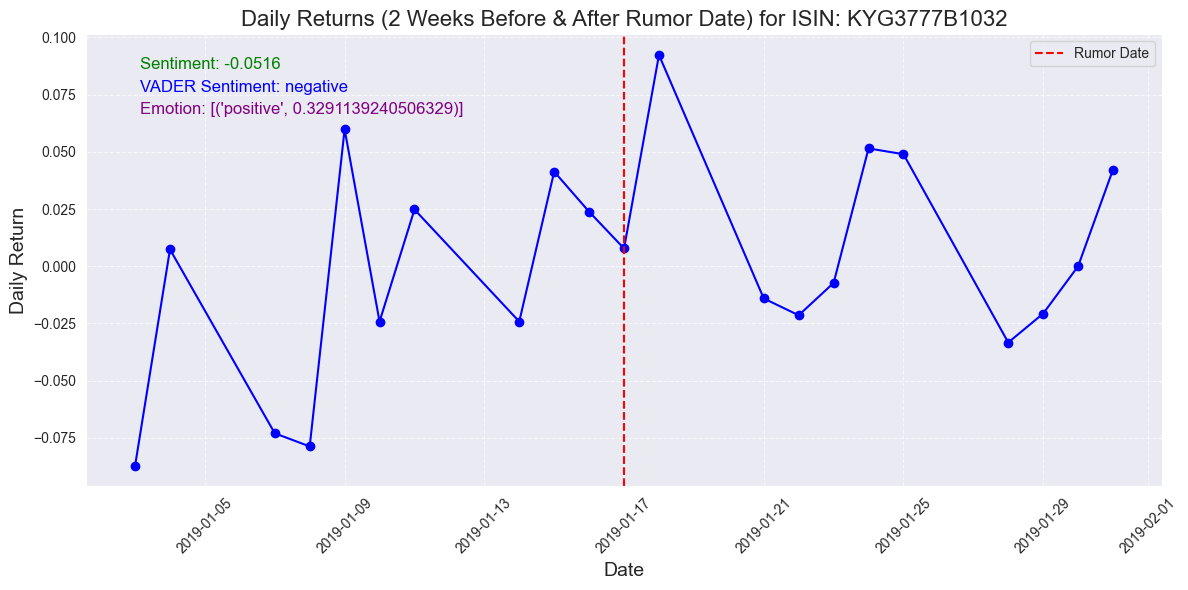

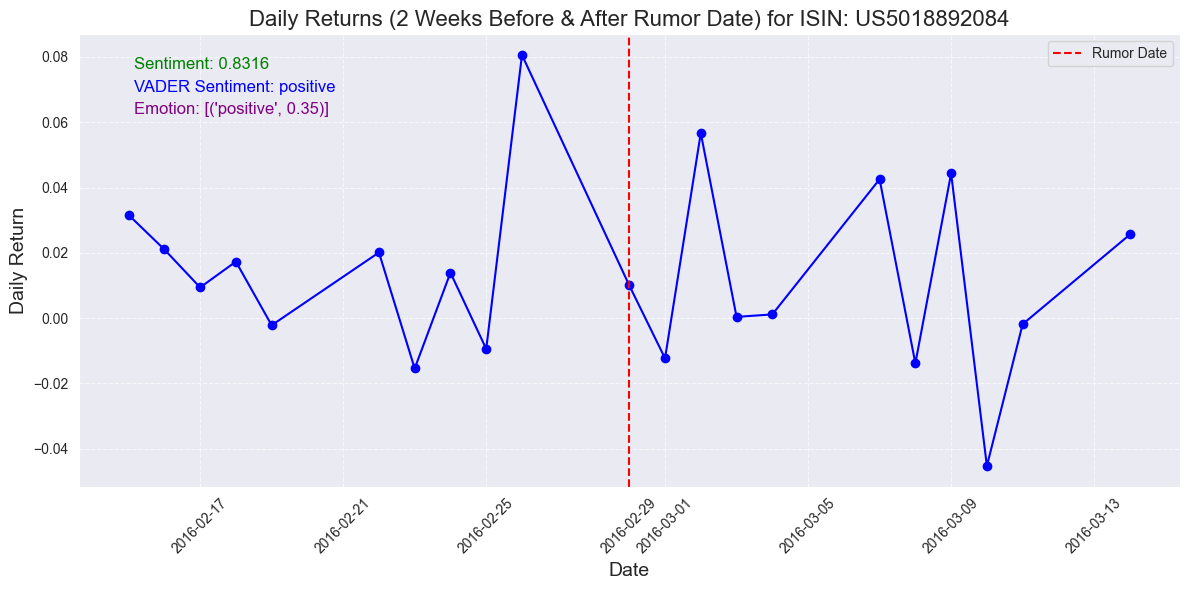

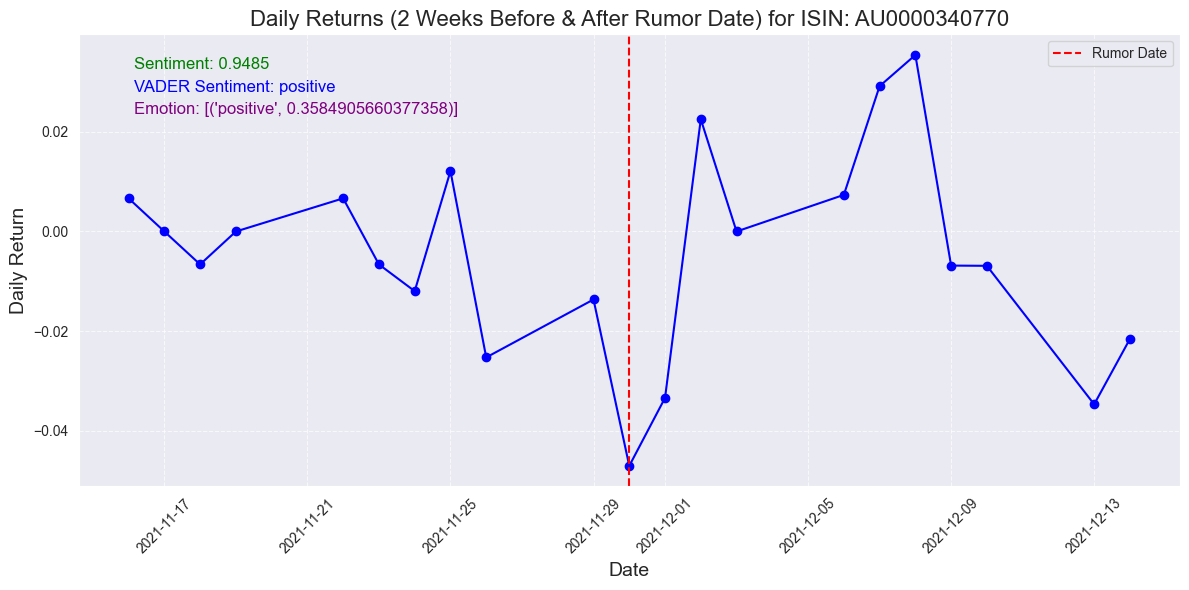

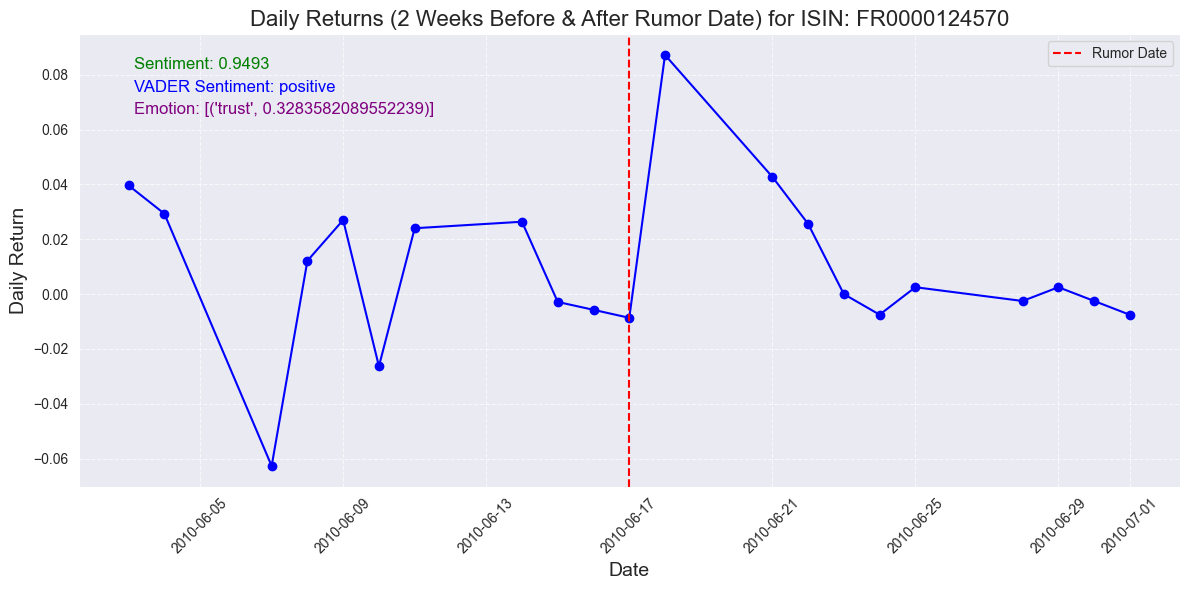

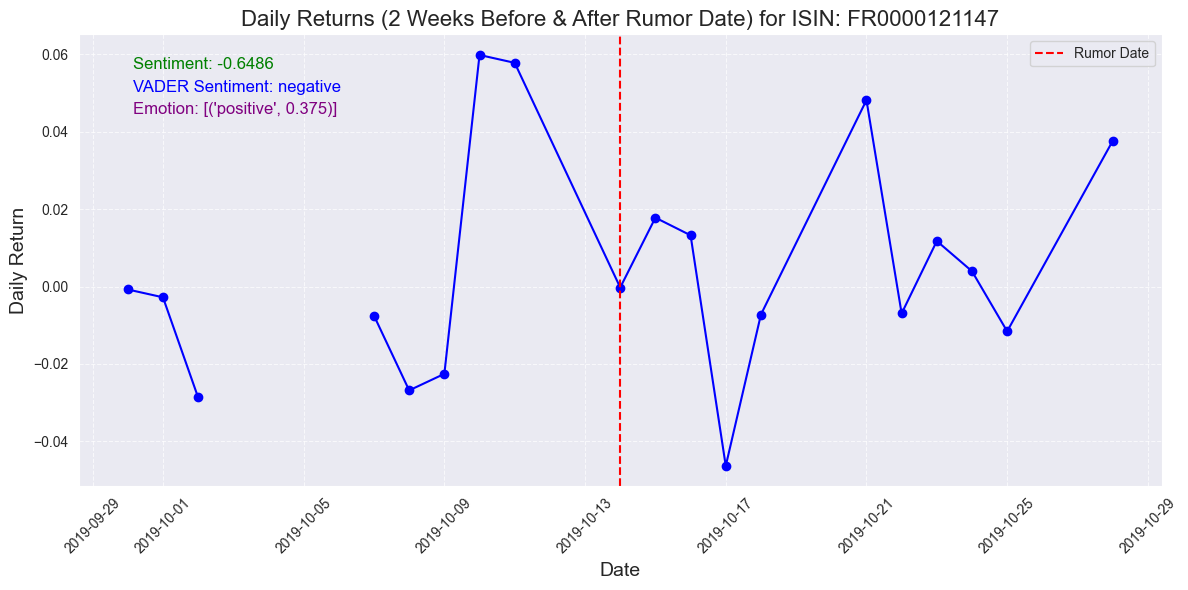

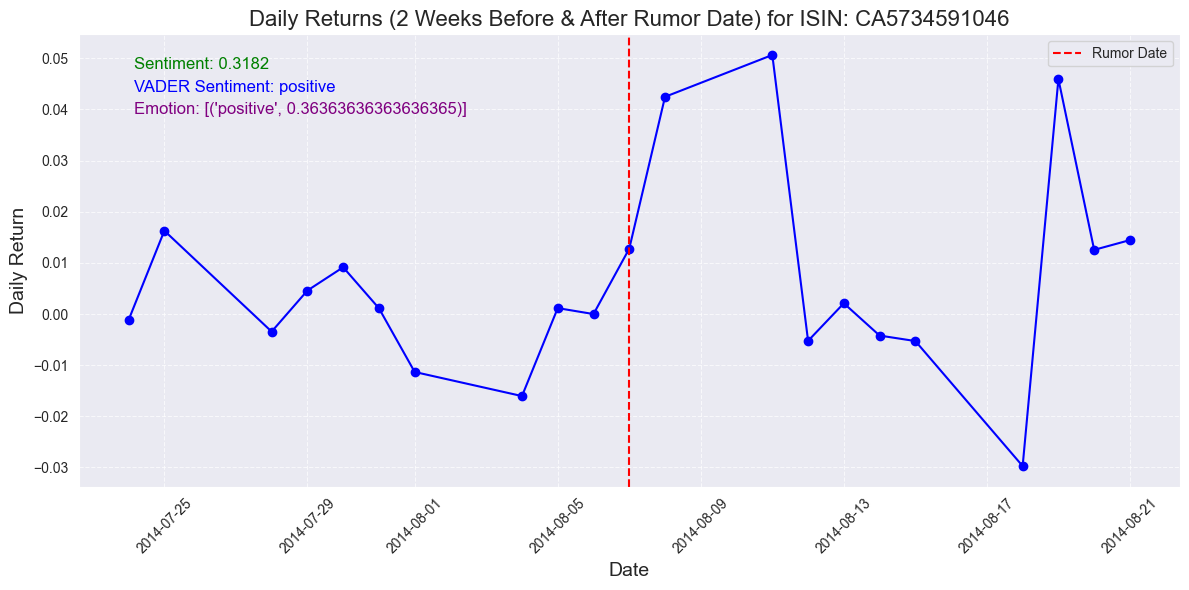

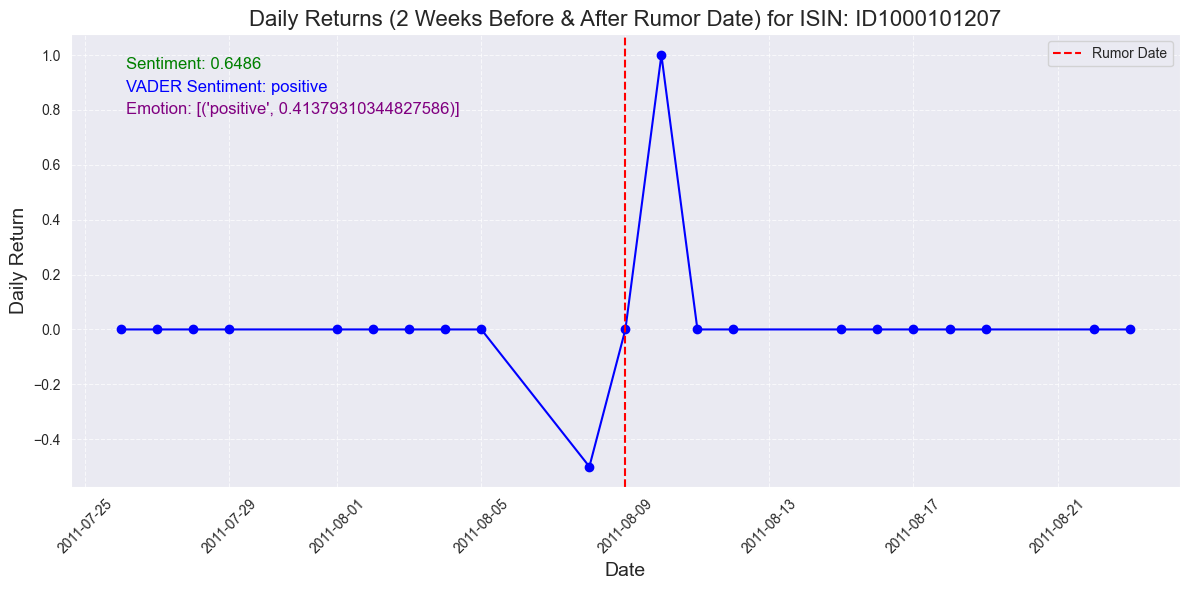

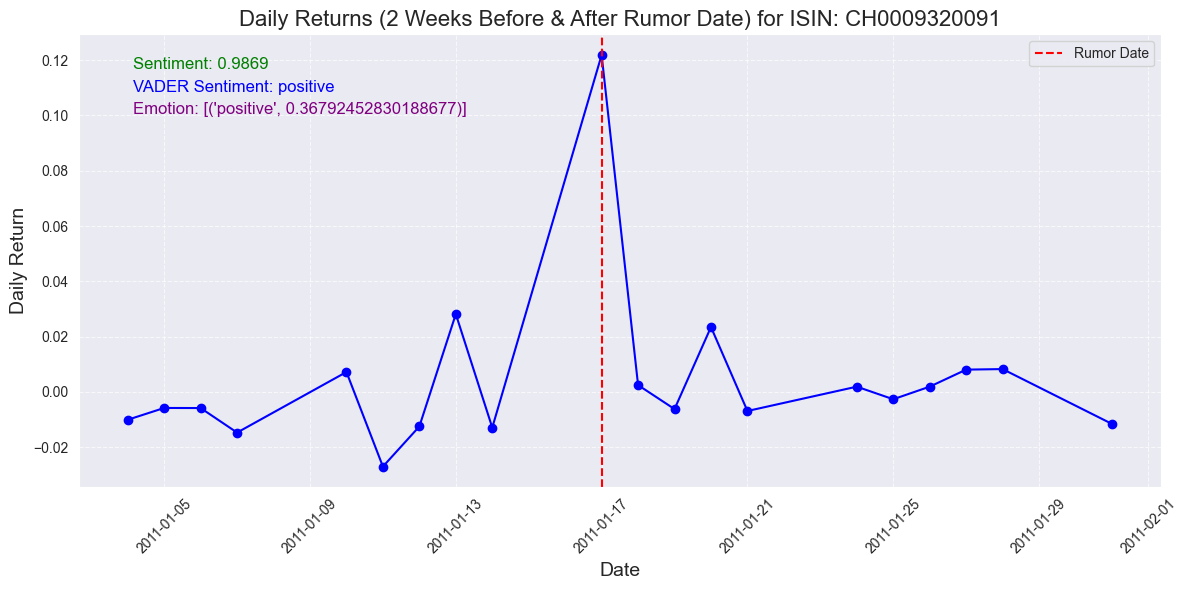

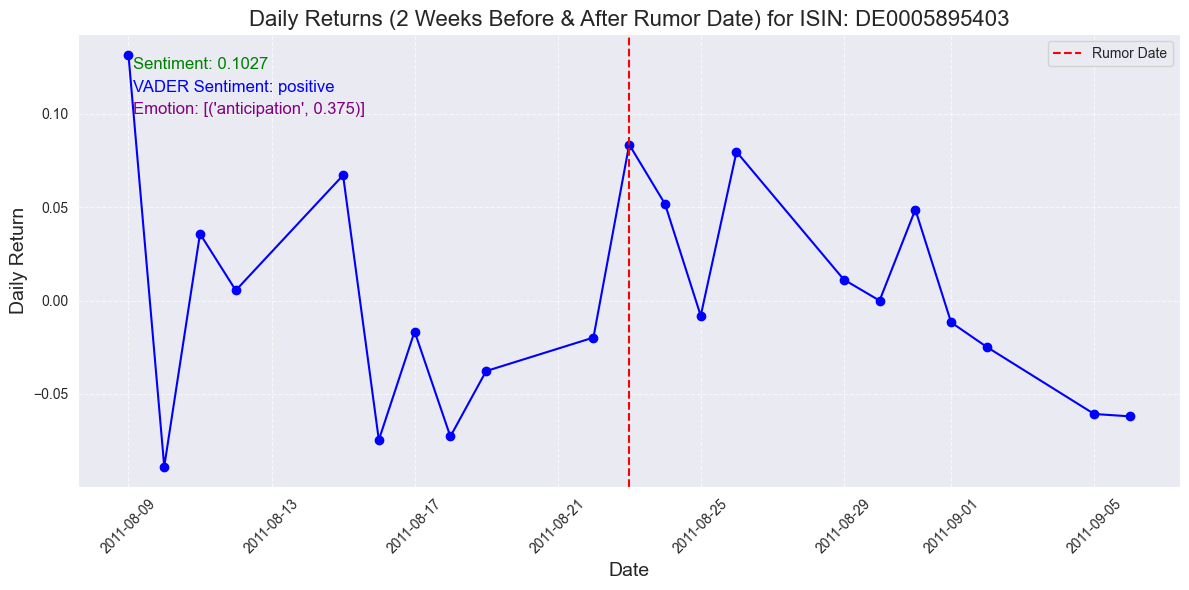

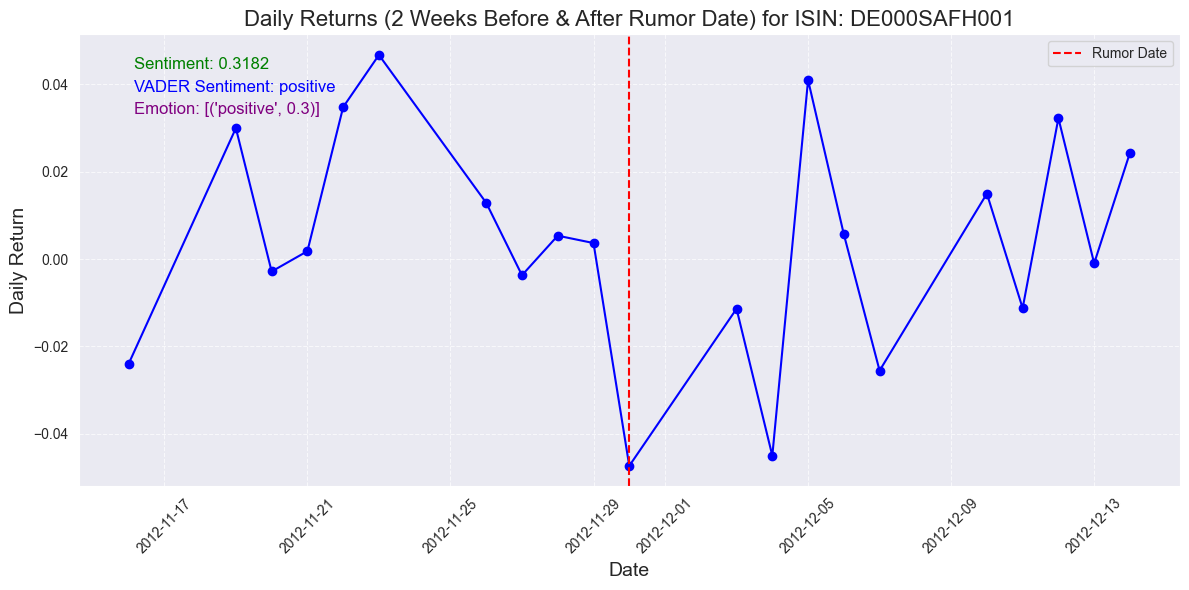

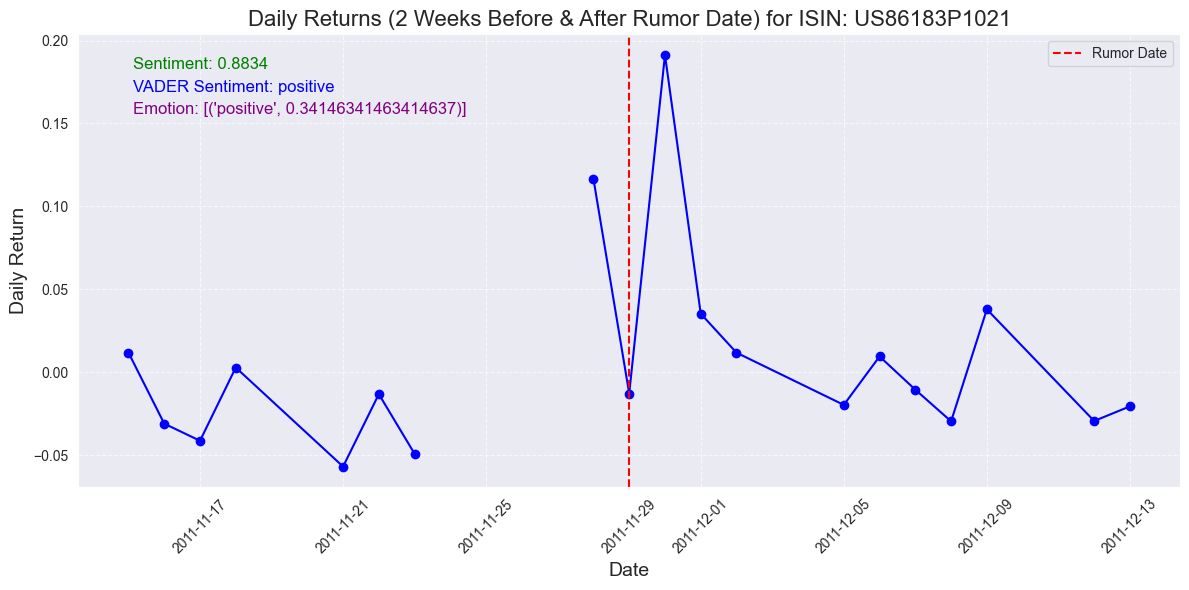

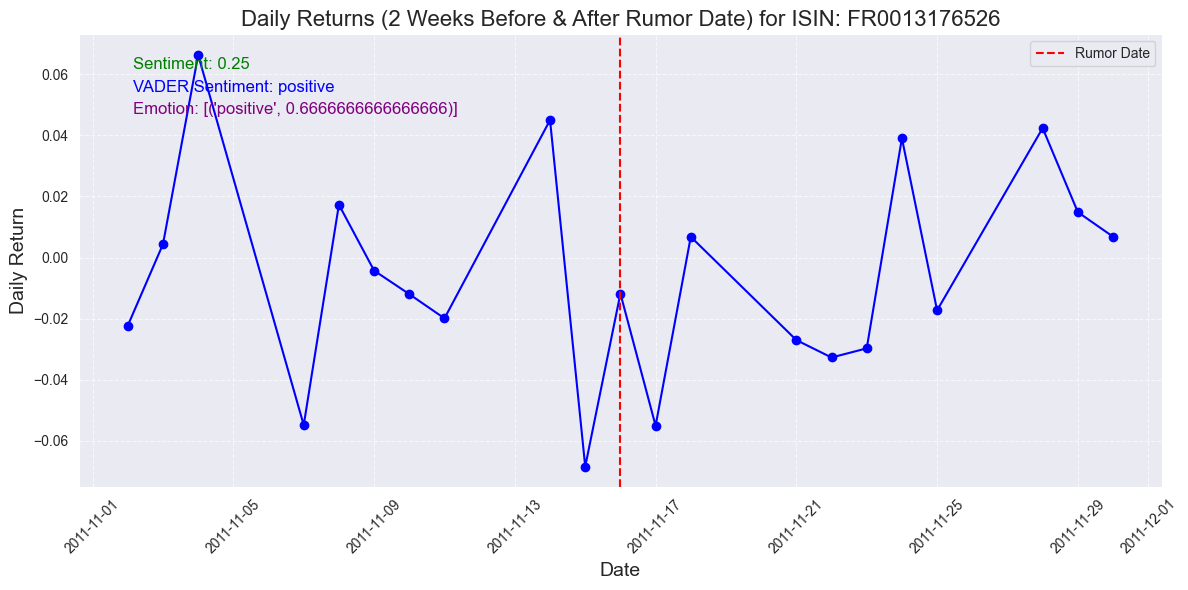

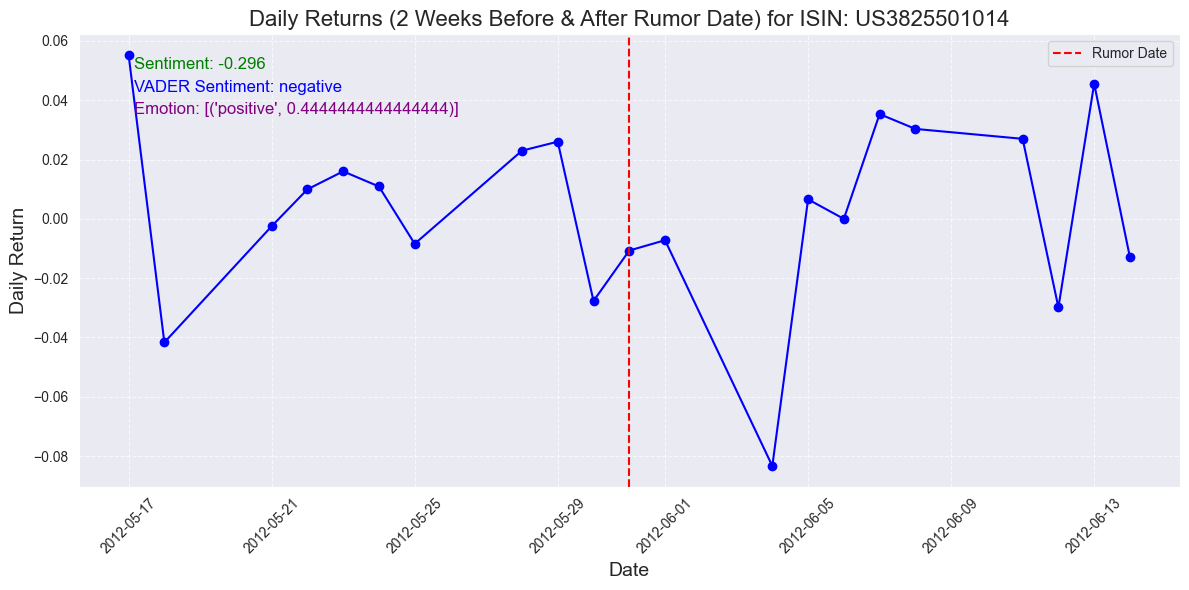

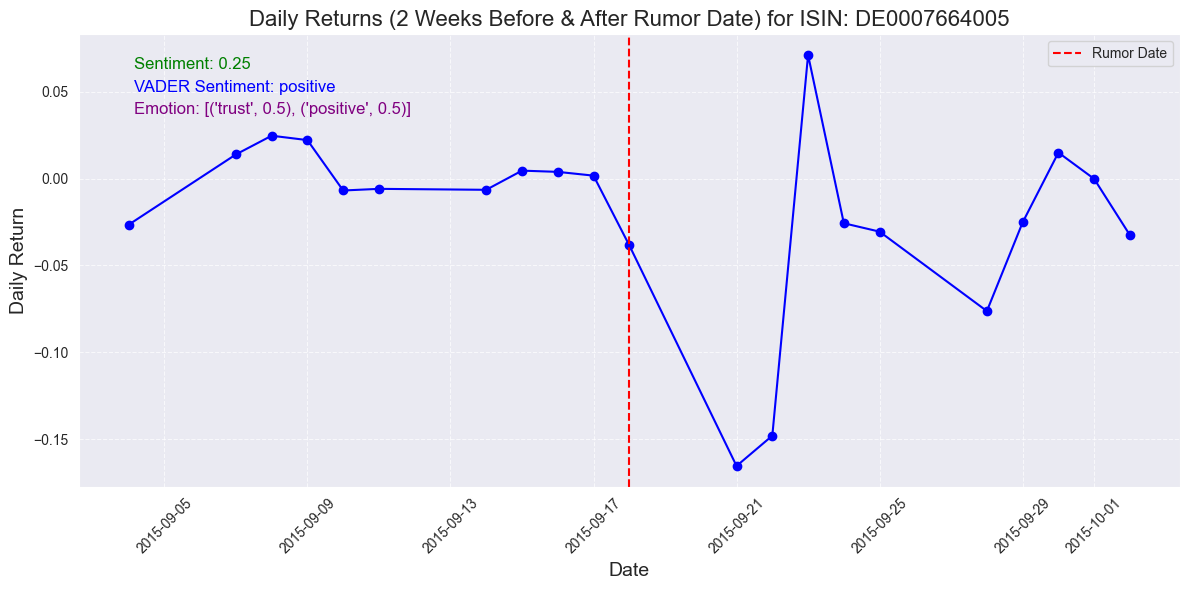

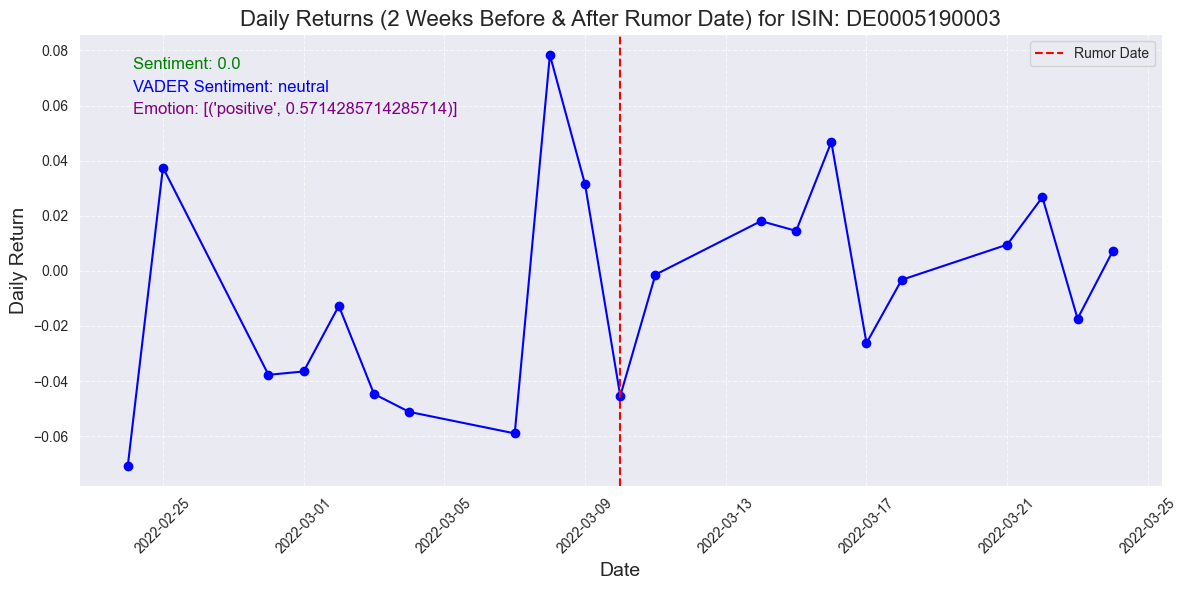

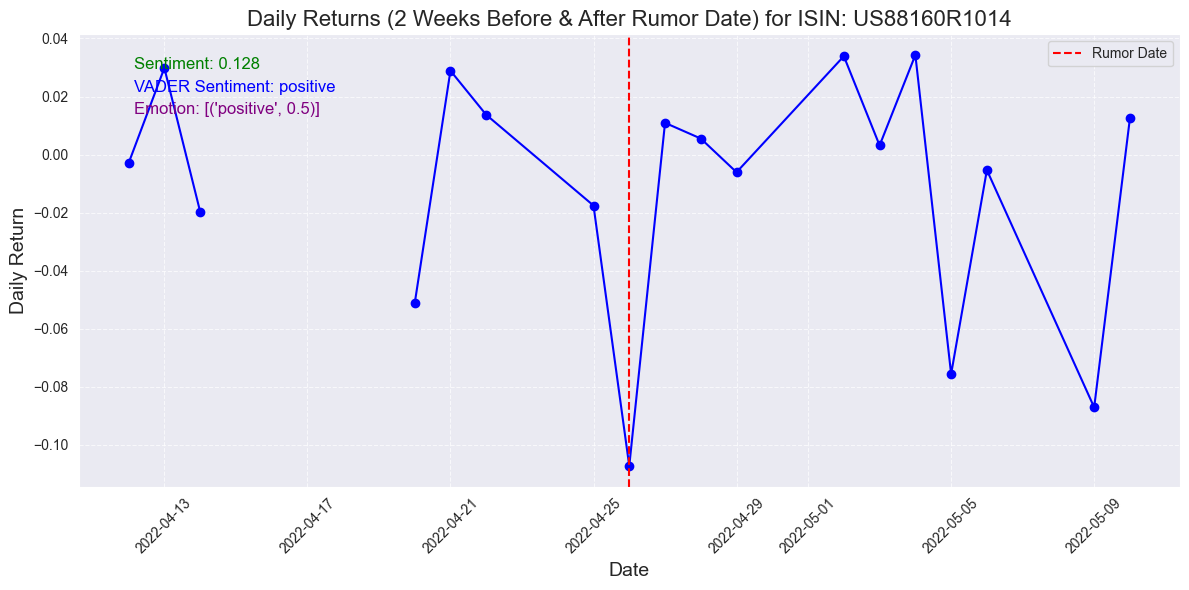

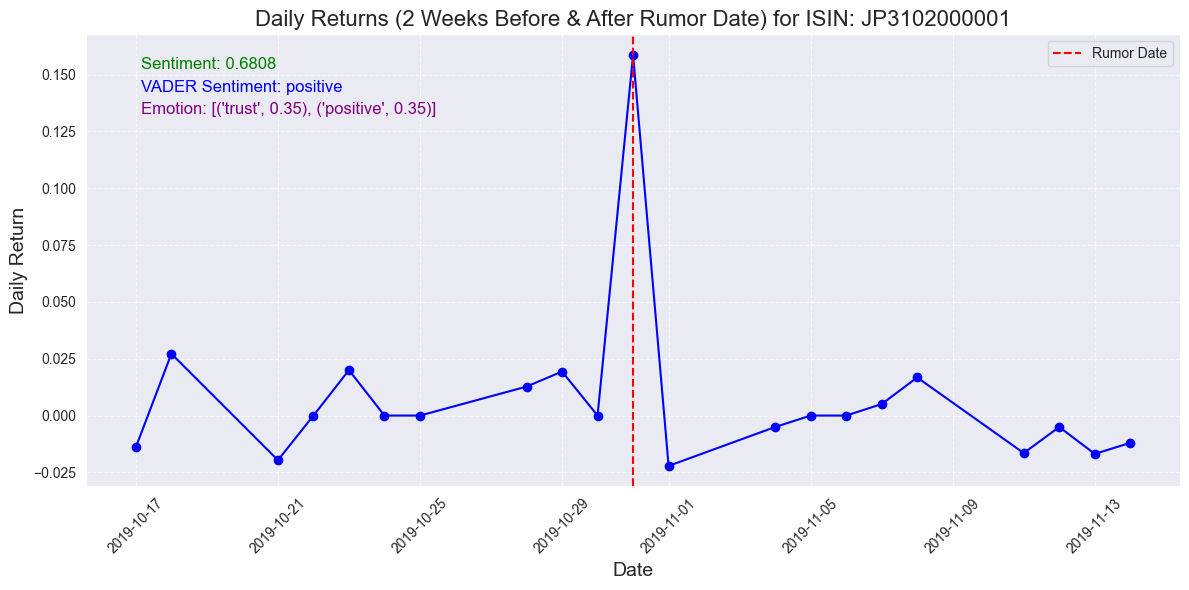

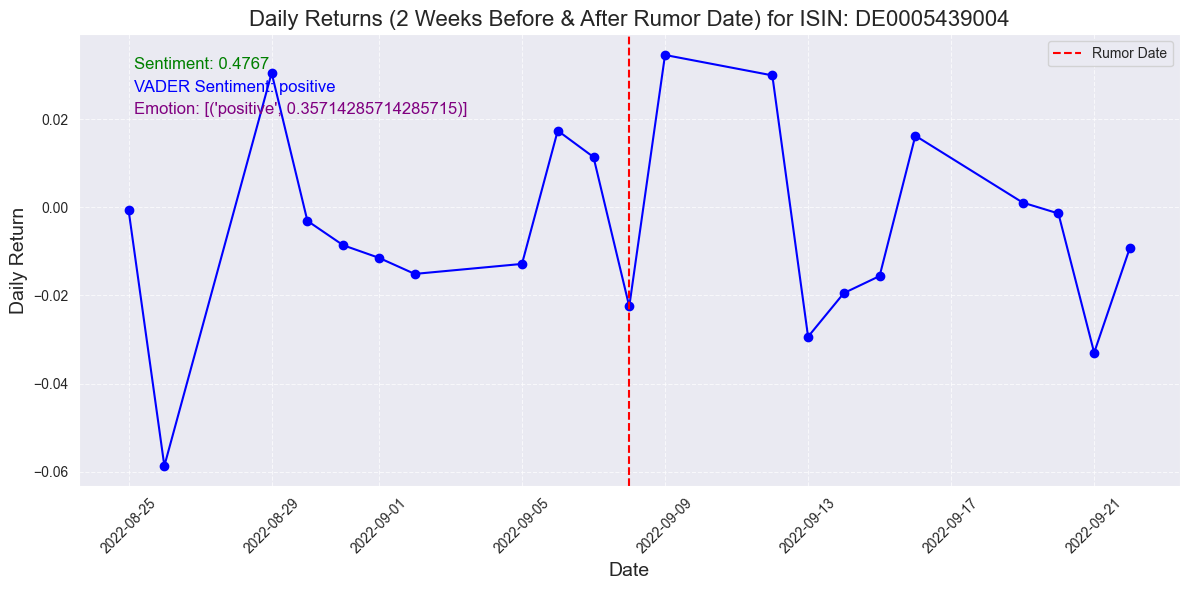

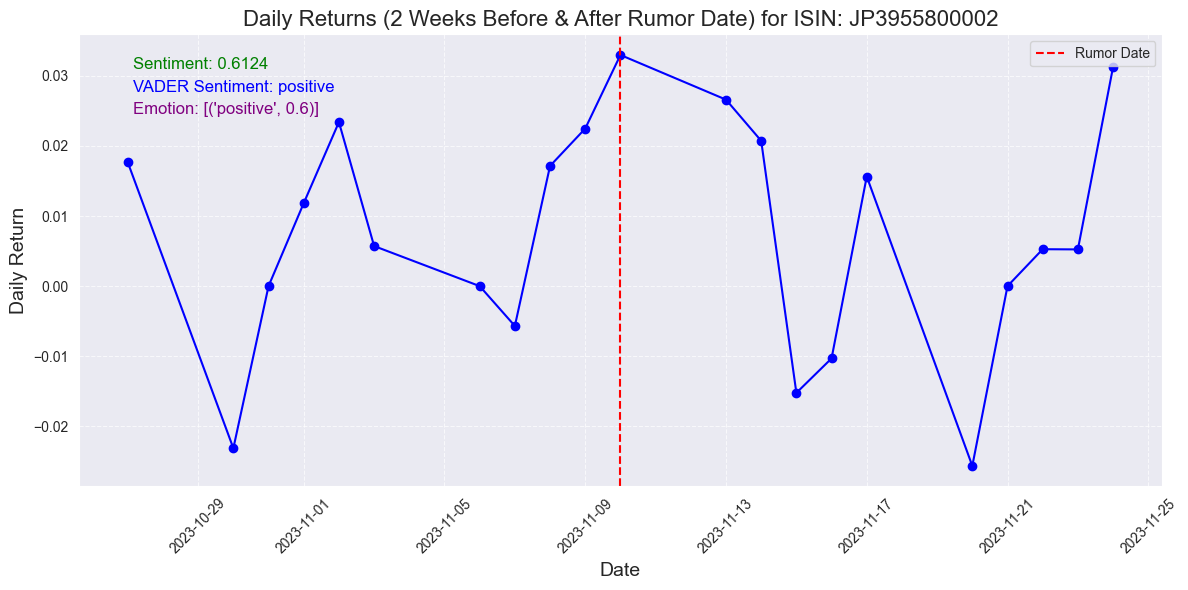

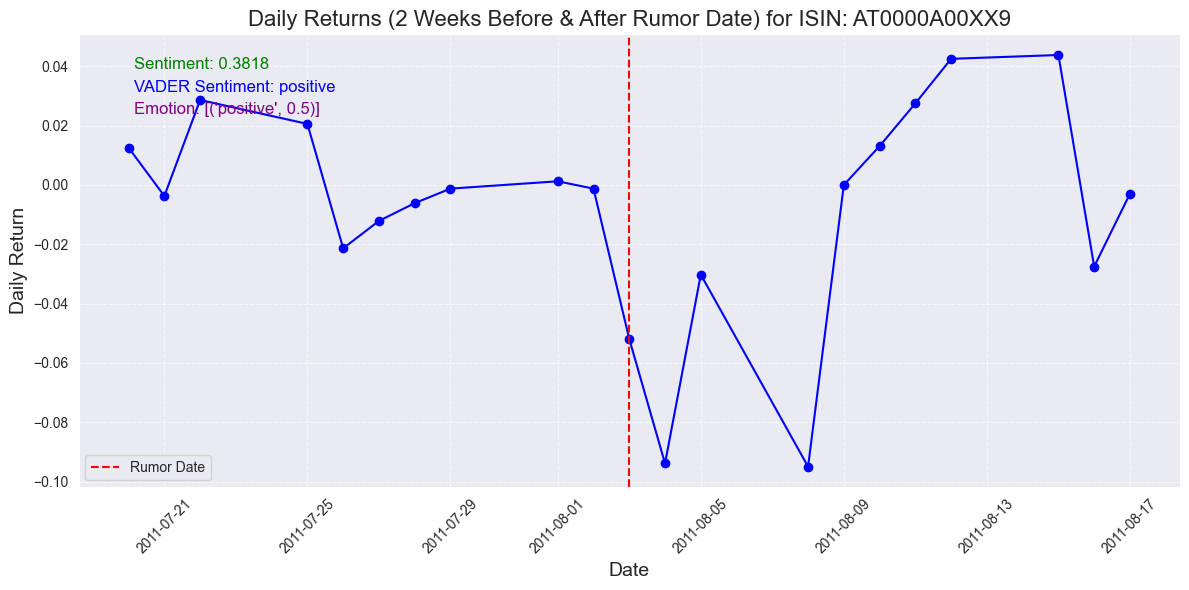

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Iterate through each ISIN in the filtered dataset
for isin in merged_data['ISIN'].unique():
    # Filter data for the specific ISIN
    isin_data = merged_data[merged_data['ISIN'] == isin]

    # Get the rumor_date for this ISIN (assuming there's only one row per ISIN)
    rumor_date = pd.to_datetime(isin_data['date_rumor'].values[0])

    # Get sentiment, vader_sentiment, and emotion for this ISIN
    sentiment = isin_data['sentiment'].values[0]  # Replace 'sentiment' with the actual column name
    vader_sentiment = isin_data['vader_sentiment'].values[0]  # Replace with correct column name
    emotion = isin_data['emotion'].values[0]  # Replace with correct column name

    # Calculate the date range (2 weeks before and 2 weeks after)
    start_date = rumor_date - pd.Timedelta(weeks=2)
    end_date = rumor_date + pd.Timedelta(weeks=2)

    # Extract the date columns within the range
    daily_returns = isin_data.filter(regex=r'\d{4}-\d{2}-\d{2}')
    date_columns = pd.to_datetime(daily_returns.columns)
    relevant_mask = (date_columns >= start_date) & (date_columns <= end_date)
    relevant_columns = date_columns[relevant_mask]
    relevant_data = daily_returns.iloc[:, relevant_mask]

    # Plot the relevant data
    plt.figure(figsize=(12, 6))
    plt.plot(relevant_columns, relevant_data.iloc[0], marker='o', linestyle='-', color='b')
    plt.axvline(rumor_date, color='r', linestyle='--', label='Rumor Date')

    # Add sentiment, Vader sentiment, and emotion as text annotations
    sentiment_text = f"Sentiment: {sentiment}"
    vader_text = f"VADER Sentiment: {vader_sentiment}"
    emotion_text = f"Emotion: {emotion}"

    # Display the annotations on the plot
    plt.text(0.05, 0.95, sentiment_text, transform=plt.gca().transAxes, fontsize=12, color='green', verticalalignment='top')
    plt.text(0.05, 0.90, vader_text, transform=plt.gca().transAxes, fontsize=12, color='blue', verticalalignment='top')
    plt.text(0.05, 0.85, emotion_text, transform=plt.gca().transAxes, fontsize=12, color='purple', verticalalignment='top')

    # Configure plot appearance
    plt.title(f'Daily Returns (2 Weeks Before & After Rumor Date) for ISIN: {isin}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Daily Return', fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
